# Naked Options Simulation in Python

## Dependencies 

In [69]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"
import yfinance as yf
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML
from ipywidgets import interact, FloatSlider

## Historical Prices


Let's download the historical price data of the stock and print the last traded price.

In [70]:
ticker='NVDA'
ticker_object= yf.Ticker(ticker)
price_data= ticker_object.history(period='max')
last= price_data['Close'].iloc[-1]
# Simplify index to just day
price_data.index = price_data.index.date
print(f'The live price of {ticker} is {last:.2f}')
display(price_data.tail())

The live price of NVDA is 183.16


,Open,High,Low,Close,Volume,Dividends,Stock Splits
2025-10-06,185.50,187.23,183.33,185.54,157678100,0.00,0.00
2025-10-07,186.23,189.06,184.00,185.04,140088000,0.00,0.00
2025-10-08,186.57,189.60,186.54,189.11,130168900,0.00,0.00
2025-10-09,192.23,195.30,191.06,192.57,182997200,0.00,0.00
2025-10-10,193.51,195.62,182.05,183.16,266534400,0.00,0.00


## Option chain retrieval

Let's fetch the option chain prices for the next expiration date that's around **3 months**.  
Time horizon and moneyness: how far from the current price we want the options (ITM, ATM, OTM).  
In this example, we will use **ITM options** at 3 months.


Let's fetch the option chain prices for the next expiration date that's around **3 months**.  

Time horizon and moneyness: how far from the current price we want the options (ITM, ATM, OTM)   
In this example, we will use **ITM options** at 3 months.


In [71]:
requested= 90 #3 months
TOLL=3/100 #how far from the current price level we want the options to show 

In [75]:
from datetime import datetime

# Load the ticker
ticker_object = yf.Ticker(ticker)

# Get all expirations
expirations = ticker_object.options

# Pick expiry ~3 months from today
closest = min(expirations, key=lambda d: abs((datetime.strptime(d, "%Y-%m-%d") - datetime.now()).days - requested))
print(f"Closest expiry to the preference of {requested} days is :", closest)

# Fetch option chain
opt_chain = ticker_object.option_chain(closest)
calls = opt_chain.calls
puts = opt_chain.puts

# Combine
options_df = pd.concat([calls.assign(type='call'), puts.assign(type='put')])

# Keep only available columns
available_cols = [c for c in ['type','strike','lastPrice','bid','ask','impliedVolatility'] if c in options_df.columns]
options_df = options_df[available_cols]

expiry_date = datetime.strptime(closest, "%Y-%m-%d").date()

# Calculate the difference (returns a timedelta)
days_to_expiry = expiry_date -  datetime.now().date()

print("Days until expiry:", days_to_expiry.days,end= '\n\n')
print("At the money options:")

atm_df= options_df[np.isclose(last,options_df.strike,rtol=TOLL,atol=TOLL)]
display(atm_df)

Closest expiry to the preference of 90 days is : 2026-01-16
Days until expiry: 97

At the money options:


,type,strike,lastPrice,bid,ask,impliedVolatility
199,call,178.00,21.37,20.80,21.15,0.50
200,call,179.00,22.32,20.25,20.60,0.49
201,call,180.00,19.81,19.80,20.00,0.49
202,call,181.00,19.25,19.25,19.45,0.49
203,call,182.00,18.80,18.70,18.90,0.49
204,call,183.00,18.35,18.20,18.35,0.48
205,call,184.00,17.73,17.55,17.85,0.48
206,call,185.00,17.25,17.15,17.45,0.48
207,call,186.00,16.72,16.65,16.95,0.48
208,call,187.00,16.30,16.15,16.35,0.48


## Black-Scholes-Merton Option Pricing Model

**Let's introduce the pricing formula for both Call and Put options.**

The **Black–Scholes–Merton (BSM)** model provides a theoretical framework to price European call and put options.  
It assumes that the underlying asset follows a *Geometric Brownian Motion* with constant volatility and interest rate.

$$
C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$

$$
P = K \cdot e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1)
$$

---

$$
d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \tfrac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}, 
\quad
d_2 = d_1 - \sigma \sqrt{T}
$$

---

$$
\begin{aligned}
C & : \text{Call option price} \\
P & : \text{Put option price} \\
S & : \text{Current stock price (spot price)} \\
K & : \text{Strike price of the option} \\
T & : \text{Time to expiration (in years)} \\
r & : \text{Risk-free interest rate} \\
\sigma & : \text{Volatility of the underlying asset} \\
N(x) & : \text{Cumulative distribution function of the standard normal distribution}
\end{aligned}
$$


In [76]:
#The same function will be used for both call and put options

def black_scholes(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    return option_price


## Choosing the strike

We can slide and retrieve the values for the desired strike price (setting the variable strike at the same time)

In [77]:
chosen_option=None


@interact(
    s=FloatSlider(
        min=int(last * 0.50),
        max=int(last * 1.50),
        step=1.0,
        value=float(options_df['strike'].median()),
        description=f'Strike Price @ {expiry_date}',
        continuous_update=False
    )
)

def show_option_rows(s):
    global strike,chosen_option
    rows = options_df.loc[options_df['strike'] == round(s)]
    strike=s
    rows.set_index("type", inplace=True)
    rows.rename(columns={rows.columns[-1]: 'ivol'}, inplace=True)
    chosen_option = rows 
    display(rows)         # shows the table interactively


interactive(children=(FloatSlider(value=205.0, continuous_update=False, description='Strike Price @ 2026-01-16…

## Outcome of a naked option

With the slider down below it's possible to take a first look of how the PnL would be at the end of the expiration date

In [81]:
df= chosen_option
# premiums and trade setup
call_ask = df.loc['call','ask']
call_bid = df.loc['call','bid']
put_ask = df.loc['put','ask']
put_bid = df.loc['put','ask']
contracts = 1 # Note that 1 contract moves 100 options 
fees = 3 #let's assume 3 dollar fees


@interact(
    final_price=FloatSlider(
        value= last,
        min=int(last * 0.50),
        max=int(last * 1.50),
        step=0.25,
        description=f"PRICE",
        continuous_update=False
    )
)

def show_pnl(final_price):
    global call_ask, call_bid, put_ask, put_bid, contracts, fees

    # BUY CALL 
    if final_price <= strike:
        pnl_buy_call = -1 * call_ask * 100 * contracts - fees * contracts
    else:
        pnl_buy_call = (final_price - strike) * 100 * contracts - call_ask * 100 * contracts - fees * contracts

    # SELL CALL
    if final_price <= strike:
        pnl_sell_call = call_bid * 100 * contracts - fees * contracts
    else:
        pnl_sell_call = (strike - final_price) * 100 * contracts + call_bid * 100 * contracts - fees * contracts

    # BUY PUT
    if final_price >= strike:
        pnl_buy_put = -1 * put_ask * 100 * contracts - fees * contracts
    else:
        pnl_buy_put = (strike - final_price) * 100 * contracts - put_ask * 100 * contracts - fees * contracts

    # SELL PUT
    if final_price >= strike:
        pnl_sell_put = put_bid * 100 * contracts - fees * contracts
    else:
        pnl_sell_put = (final_price - strike) * 100 * contracts + put_bid * 100 * contracts - fees * contracts

    print(f"Strike {strike} @ {expiry_date}",end= '\n\n')
    print(f"Buy Call  PnL: {pnl_buy_call:.2f}$")
    print(f"Sell Call PnL: {pnl_sell_call:.2f}$")
    print(f"Buy Put   PnL: {pnl_buy_put:.2f}$")
    print(f"Sell Put  PnL: {pnl_sell_put:.2f}$")


interactive(children=(FloatSlider(value=183.16000366210938, continuous_update=False, description='PRICE', max=…

The PnL calculations implemented here represent the terminal payoff of the option positions at expiration, based solely on the underlying’s final settlement price relative to the strike. They do not incorporate path-dependent factors such as time decay (theta), changes in implied volatility (vega), delta-hedging adjustments, or intermediate mark-to-market fluctuations prior to expiry. As a result, these values reflect theoretical end-of-life outcomes rather than the realized PnL trajectory over the option’s lifetime.

$$
\text{We should consider the Option Greeks}
$$
**Definitions:**

- **Delta ($\Delta$)**: Measures the sensitivity of the option price $C$ (or $P$) to changes in the underlying asset price $S$:  
  $$
  \Delta = \frac{\partial C}{\partial S} \quad \text{or} \quad \Delta = \frac{\partial P}{\partial S}
  $$

- **Gamma ($\Gamma$)**: Measures the rate of change of delta with respect to changes in the underlying asset price:  
  $$
  \Gamma = \frac{\partial \Delta}{\partial S} = \frac{\partial^2 C}{\partial S^2}
  $$

- **Theta ($\Theta$)**: Measures the sensitivity of the option price to the passage of time (time decay):  
  $$
  \Theta = \frac{\partial C}{\partial t} \quad \text{or} \quad \Theta = \frac{\partial P}{\partial t}
  $$

- **Vega ($\nu$)**: Measures the sensitivity of the option price to changes in volatility $\sigma$ of the underlying asset:  
  $$
  \nu = \frac{\partial C}{\partial \sigma} \quad \text{or} \quad \nu = \frac{\partial P}{\partial \sigma}
  $$



In [82]:
#The same function will be used for all the greeks

def greeks_calc(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        delta = norm.cdf(d1)
        theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))- r*K*np.exp(-r*T)*norm.cdf(d2)
        gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
        vega= S*norm.pdf(d1)*np.sqrt(T)
        
    elif option_type == 'put':
        delta = -norm.cdf(-d1)
        theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))+ r*K*np.exp(-r*T)*norm.cdf(-d2)
        gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
        vega= S*norm.pdf(d1)*np.sqrt(T)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return delta,gamma,vega,theta



## GBM Simulation

In this section, we simulate the possible evolution of a stock price using a **Geometric Brownian Motion (GBM)** model, which is commonly used in quantitative finance for modeling asset prices.

We start by calculating key parameters from historical price data:  

- **Drift (μ):** The average expected return, annualized.  
- **Volatility (σ):** The standard deviation of returns, annualized.  

The **stochastic GBM model** is described by the differential equation:

$$
dS = \mu S \, dt + \sigma S \, dW
$$

where:  
- $S$ is the **stock price**,  
- $dW$ is the **increment of a Wiener process (Brownian motion)**.  

The **discrete-time simulation** uses the exact solution:

$$
S_t = S_0 \exp\Big((\mu - 0.5 \sigma^2)t + \sigma W_t\Big)
$$

where $W_t$ is the cumulative sum of random normal increments. The term $-0.5 \sigma^2$ adjusts for variance so that the **expected drift remains μ**.  

We also compare this to a **deterministic drift-only path**:

$$
S_\text{det}(t) = S_0 \exp(\mu t)
$$

This comparison allows us to visually see the effect of **stochastic fluctuations** versus **pure deterministic growth**.  

In the plot, the **blue line** represents the stochastic GBM path, while the **orange dashed line** shows the deterministic drift-only path.


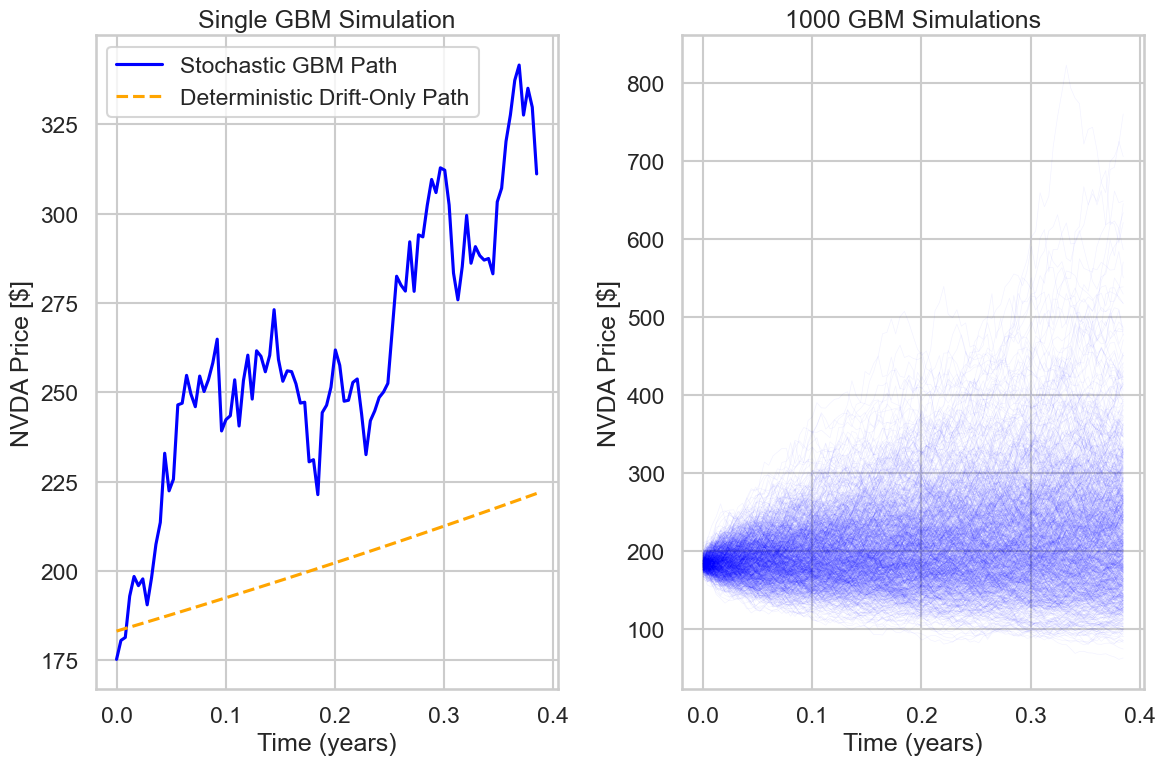

In [83]:
# Parameters from historical data 
daily_returns = price_data['Close'].pct_change().dropna()
mu = daily_returns.mean() * 252                # annualized drift
sigma = daily_returns.std() * np.sqrt(252)     # annualized volatility

# Simulation parameters 
S0 = last                                      # current price
N = days_to_expiry.days                        # number of steps (trading days) to expiry
T = N / 252                                    # time in years
dt = T / N                                     # time step
t = np.linspace(0, T, N)

# Single GBM Simulation 
dW = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(dW)

S_gbm = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
S_det = S0 * np.exp(mu * t)

# Plot side by side 
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# LEFT: single paths
axes[0].plot(t, S_gbm, label="Stochastic GBM Path", color='blue')
axes[0].plot(t, S_det, '--', label="Deterministic Drift-Only Path", color='orange')
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel(f"{ticker} Price [$]")
axes[0].set_title("Single GBM Simulation")
axes[0].legend()
axes[0].grid(True)

# RIGHT: 1000 GBM simulations
N_sim = 1000
for sim in range(N_sim):
    dW_sim = np.random.normal(0, np.sqrt(dt), size=N)
    W_sim = np.cumsum(dW_sim)
    S_sim = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W_sim)
    axes[1].plot(t, S_sim, color='blue', linewidth=0.5, alpha=0.05)

axes[1].set_xlabel("Time (years)")
axes[1].set_ylabel(f"{ticker} Price [$]")
axes[1].set_title("1000 GBM Simulations")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Parameters for the calculation 

Before pricing options or running further simulations, we define the **key parameters** based on market data and the results of previous GBM simulations.

**Core Parameters**

- $N$ – Number of trading days until expiry  
- $T$ – Time to expiry in years  
- $S_0$ – Current underlying stock price  
- $K$ – Strike price of the option  
- $r$ – Risk-free interest rate  
- $\sigma$ – Implied volatility



In [84]:
# Parameters
N = days_to_expiry.days
T = N / 252 #has to be in years

S0 = last

strike_price = strike

#Assume that the volatility doesnt change
volatility = chosen_option.ivol
vol_call = volatility['call']
vol_put = volatility['put']


r= 0.025 #interest rate



## Option Evolution Over Time



Assuming a **similar implied volatility** along the period, we calculate how the **option premium** would change according to the **underlying asset price** over the time window.  

This allows us to visualize how **price movements of the underlying** affect the **value of calls and puts** over time, providing insight into potential profits or losses under different market scenarios.


In [85]:
#vectorized calculus
t = np.linspace(T, dt, N)  # decreasing time to expiration
stock_prices = S_gbm

call_prices = np.array([black_scholes('call', S, strike_price, tau, r, vol_call) 
                        for S, tau in zip(stock_prices, t)])
put_prices = np.array([black_scholes('put', S, strike_price, tau, r, vol_put) 
                       for S, tau in zip(stock_prices, t)])

# Greeks
deltas_call, gamma_c, vega_c, thetas_call = zip(*[
    greeks_calc('call', S, strike_price, tau, r, vol_call) 
    for S, tau in zip(stock_prices, t)
])
deltas_put, gamma_p, gamma_p, thetas_put = zip(*[
    greeks_calc('put', S, strike_price, tau, r, vol_put) 
    for S, tau in zip(stock_prices, t)
])

deltacalls = np.array(deltas_call)
deltaputs = np.array(deltas_put)
thetacalls = np.array(thetas_call)/365
thetaputs = np.array(thetas_put)/365

## Vectorizing the PnL

The entire history of the option prices along the simulated path is captured in call_prices and put_prices. We now have to compute the value of the PnL 

In [86]:
#lets force the array to be in our specific condition at the start
call_prices[0] = df.loc['call','ask']
put_prices[0] = df.loc['put','ask']

buyC = (call_prices - df.loc['call','ask']  ) * contracts*100 - fees
sellC = (df.loc['call','bid'] - call_prices  ) * contracts*100 - fees

buyP = (put_prices - df.loc['put','ask'] ) * contracts*100 - fees
sellP = (df.loc['put','bid'] - put_prices ) * contracts*100 - fees

Now we have a more realistic PnL for each of the 4 cases of simple buy or sell naked call/put options

## Results of the simulation

In the following chart, we represent:

**1)**   The GBM simulation of the underlying price we computed earlier and its effect on the option price over the days until expiration (assuming constant implied    volatility).

**2)**   The P&L trajectory of each naked option throughout the period.

**3-4)** The evolution of Theta and Delta over time.

The simulation can also be extended by assuming a decreasing implied volatility as expiration approaches.

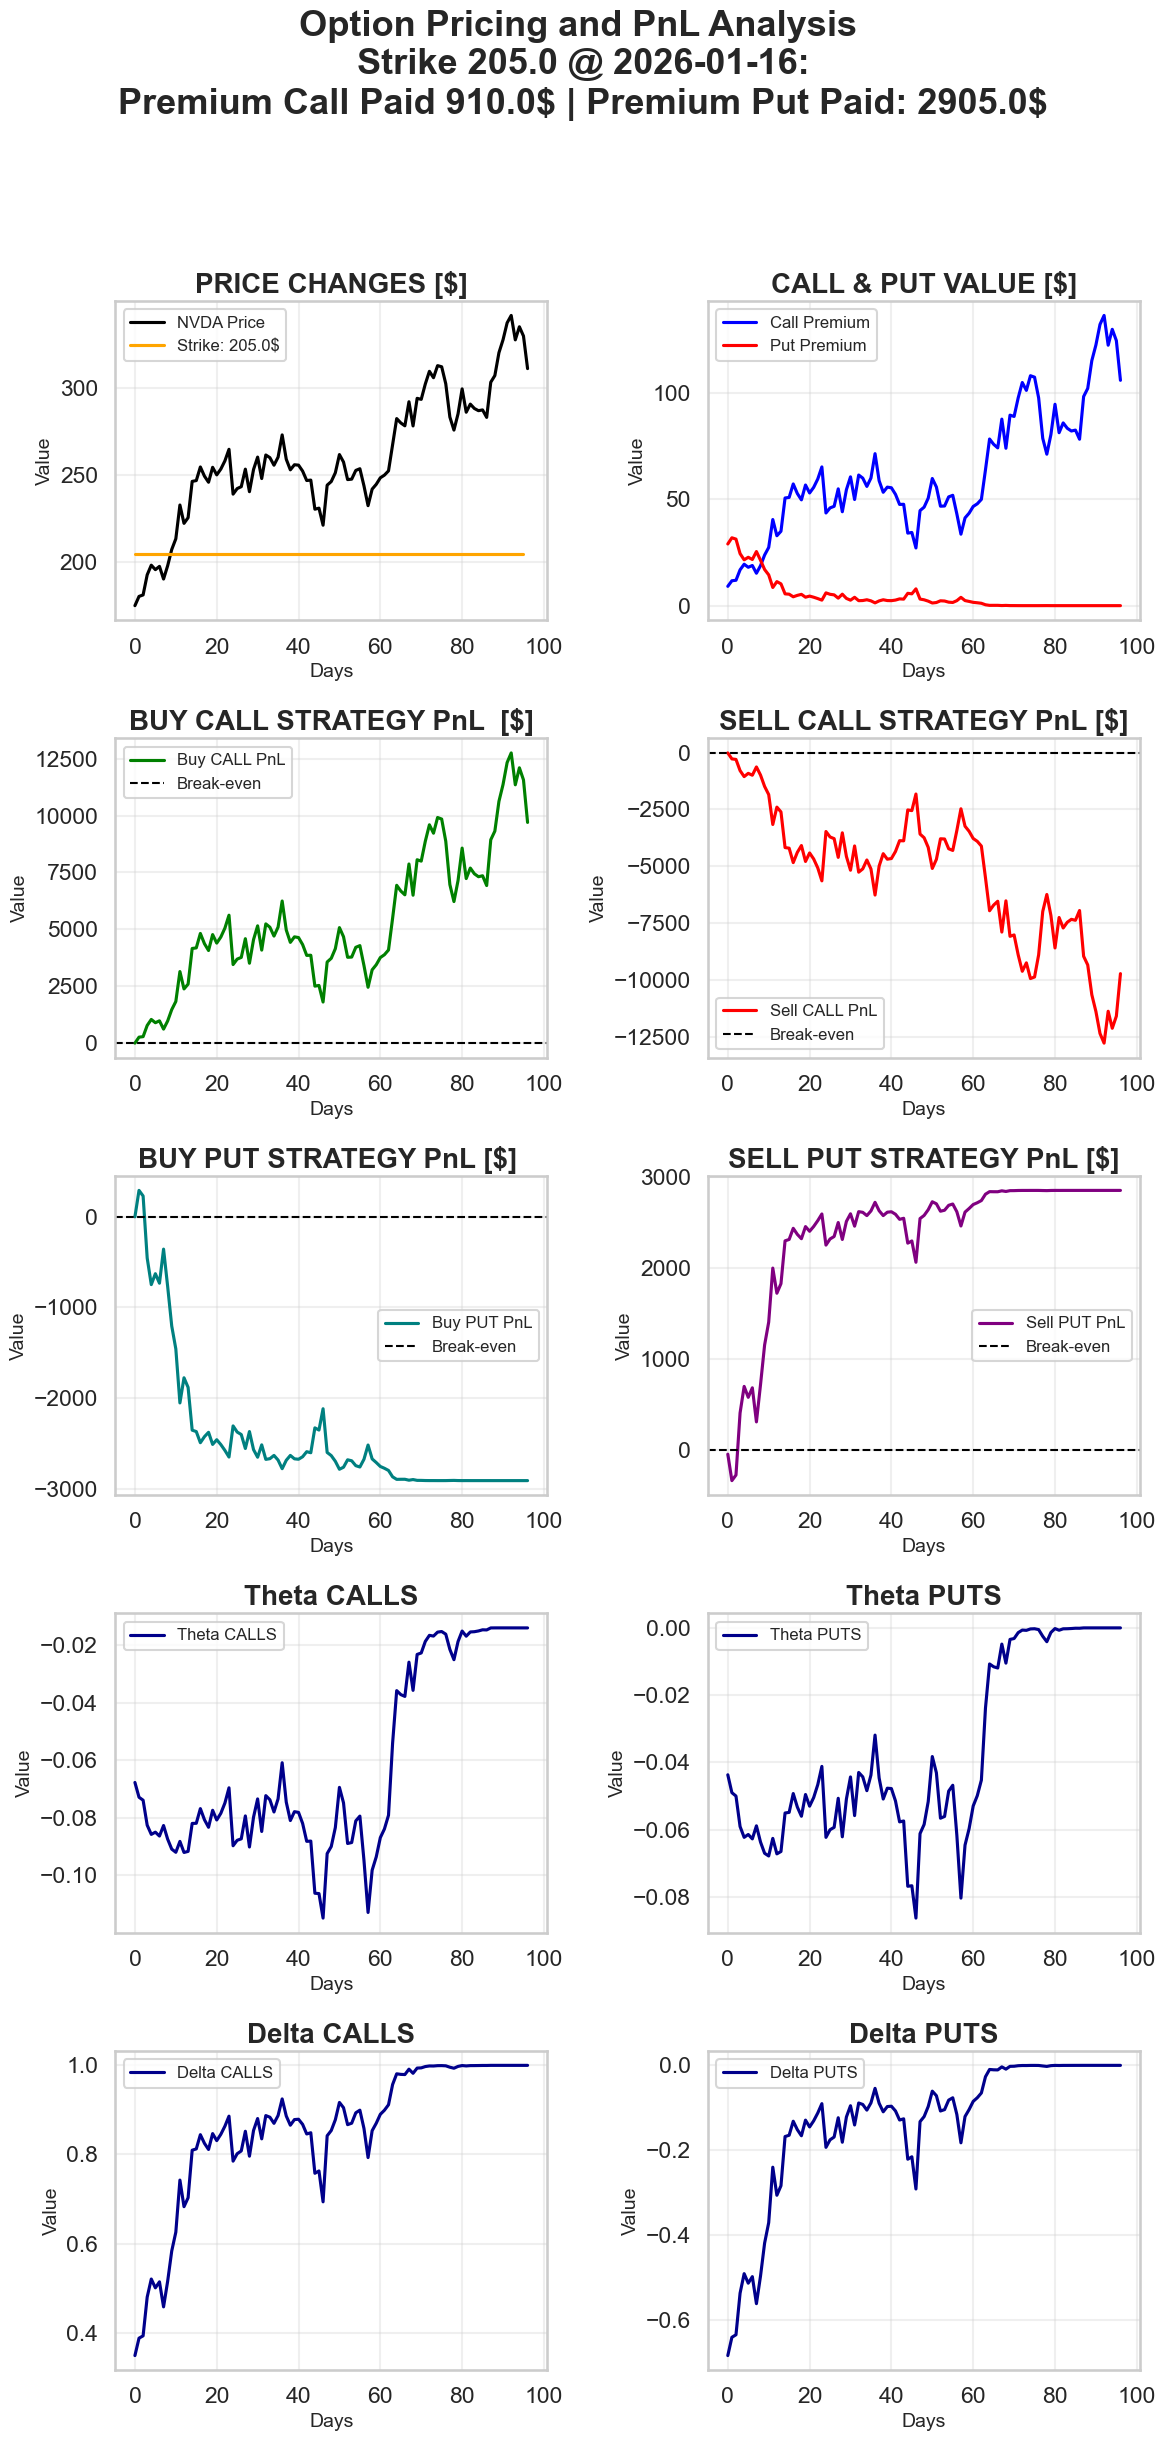

In [87]:
sns.set(style= "whitegrid", context="talk", palette="deep")

# Create Figure and Axes
fig, axes = plt.subplots(5, 2, figsize=(12, 24))
axes = axes.flatten()

#Creating the array for the strike price on the charts
strikearray=np.ones_like(np.arange(1,len(stock_prices)))*strike_price

fig.suptitle(
    f"Option Pricing and PnL Analysis \n Strike {strike} @ {expiry_date}: \nPremium Call Paid {round(df.loc['call','ask'] ,2)*100}\$ | Premium Put Paid: {round(df.loc['put','ask'],2)*100}\$",
    fontsize=26, fontweight="bold", y=1.02
)

# PRICE CHANGES (GEOMETRIC BROWNIAN MOTION)
sns.lineplot(x=np.arange(len(stock_prices)), y=stock_prices, ax=axes[0], label=f"{ticker} Price", color="black")
sns.lineplot(x=np.arange(len(strikearray)), y=strikearray, ax=axes[0], label=f"Strike: {strike_price}$", color="orange")
axes[0].set_title("PRICE CHANGES [$]", fontsize=20, fontweight="bold")

# CALL & PUT PRICE SIMULATION CHART
sns.lineplot(x=np.arange(len(call_prices)), y=call_prices, ax=axes[1], label="Call Premium", color="blue")
sns.lineplot(x=np.arange(len(put_prices)), y=put_prices, ax=axes[1], label="Put Premium", color="red")
axes[1].set_title("CALL & PUT VALUE [$]", fontsize=20, fontweight="bold")


# BUY CALL PnL 
sns.lineplot(x=np.arange(len(buyC)), y=buyC, ax=axes[2], label="Buy CALL PnL", color="green")
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1.5, label='Break-even')
axes[2].set_title("BUY CALL STRATEGY PnL  [$]", fontsize=20, fontweight="bold")

# SELL CALL PnL
sns.lineplot(x=np.arange(len(sellC)), y=sellC, ax=axes[3], label="Sell CALL PnL", color="red")
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1.5, label='Break-even')
axes[3].set_title("SELL CALL STRATEGY PnL [$]", fontsize=20, fontweight="bold")

# BUY PUT PnL 
sns.lineplot(x=np.arange(len(buyP)), y=buyP, ax=axes[4], label="Buy PUT PnL", color="teal")
axes[4].axhline(y=0, color='black', linestyle='--', linewidth=1.5, label='Break-even')
axes[4].set_title("BUY PUT STRATEGY PnL [$] ", fontsize=20, fontweight="bold")

# SELL PUT PnL
sns.lineplot(x=np.arange(len(sellP)), y=sellP, ax=axes[5], label="Sell PUT PnL", color="purple")
axes[5].axhline(y=0, color='black', linestyle='--', linewidth=1.5, label='Break-even')
axes[5].set_title("SELL PUT STRATEGY PnL [$]", fontsize=20, fontweight="bold")

# Theta CALLS 
sns.lineplot(x=np.arange(len(thetacalls)), y=thetacalls, ax=axes[6], label="Theta CALLS", color="darkblue")
axes[6].set_title("Theta CALLS", fontsize=20, fontweight="bold")

# Theta PUTS 
sns.lineplot(x=np.arange(len(thetaputs)), y=thetaputs, ax=axes[7], label="Theta PUTS", color="darkblue")
axes[7].set_title("Theta PUTS", fontsize=20, fontweight="bold")

# Delta CALLS 
sns.lineplot(x=np.arange(len(deltacalls)), y=deltacalls, ax=axes[8], label="Delta CALLS", color="darkblue")
axes[8].set_title("Delta CALLS", fontsize=20, fontweight="bold")

# Delta PUTS 
sns.lineplot(x=np.arange(len(deltaputs)), y=deltaputs, ax=axes[9], label="Delta PUTS", color="darkblue")
axes[9].set_title("Delta PUTS", fontsize=20, fontweight="bold")

#Labeling and Legends
for ax in axes:
    ax.set_xlabel("Days", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


## Interactive 3D PnL Surfaces

We built interactive 3D surfaces to explore how an option’s **PnL** evolves under different scenarios.  

1. **PnL vs Time to Expiry vs Strike:**  
   This surface shows how the PnL of each option changes with **time to expiry** and **different strike prices**. It allows you to visualize the effect of strike selection on potential gains and losses. A **break-even plane** is also included to highlight where the strategy neither gains nor loses.  

2. **PnL vs Time to Expiry vs Implied Volatility:**  
   In this scenario, the surface illustrates how PnL evolves with **time to expiry** and **changing implied volatility**, keeping the strike fixed. This helps to understand the sensitivity of option strategies to volatility movements. Dropdown buttons allow switching between **buy/sell Call and Put** strategies interactively.  

Charts are generated leveraging plotly the numpy meshgrid function. It allowes us to create all combinations of two sets of values (One axis varies while the other is “copied” along that axis)

These interactive charts make it easier to **compare strategies** and analyze the impact of **key parameters** on option performance over time.

#### What happens at different strikes?

The assumption of having the same implied volatility might be reasonable for strike prices close to that of the option we initially selected. However, as we move further in-the-money (ITM) or out-of-the-money (OTM), the variation in implied volatility should be accounted for and appropriately modeled.

In [56]:
# TIME & STRIKE GRID 
strikes = np.linspace(0.5*strike_price, 1.5*strike_price, 50) #lets change it linearly
time_days = np.arange(len(stock_prices))
taus = time_days / 252
T_mesh, K_mesh = np.meshgrid(time_days, strikes)

#  GENERIC PnL FUNCTION 
def pnl_surface(position, option_type, premium, vol):
    pnl = np.zeros_like(T_mesh, dtype=float)
    for i, K in enumerate(strikes):
        for j, (S, tau) in enumerate(zip(stock_prices, taus)):
            price = black_scholes(option_type, S, K, tau, r, vol)
            if position == 'buy':
                pnl[i,j] = (price - premium) * contracts * 100 - fees
            else:
                pnl[i,j] = (premium - price) * contracts * 100 - fees
    return pnl

# CALCULATE SURFACES 
buy_call_pnl  = pnl_surface('buy',  'call', df.loc['call','ask'], vol_call)
sell_call_pnl = pnl_surface('sell', 'call', df.loc['call','bid'], vol_call)
buy_put_pnl   = pnl_surface('buy',  'put',  df.loc['put','ask'],  vol_put)
sell_put_pnl  = pnl_surface('sell', 'put',  df.loc['put','bid'],  vol_put)

bep_plane = np.zeros_like(T_mesh)

#  CREATE 4 SEPARATE 3D PLOTS 
plots = [
    (buy_call_pnl,  "Buy Call PnL",  'Viridis'),
    (sell_call_pnl, "Sell Call PnL", 'Reds'),
    (buy_put_pnl,   "Buy Put PnL",   'Blues'),
    (sell_put_pnl,  "Sell Put PnL",  'Purples')
]

# CREATE ONE INTERACTIVE PLOT WITH DROPDOWN 
fig1 = go.Figure()

# Default trace
fig1.add_trace(go.Surface(x=T_mesh, y=K_mesh, z=buy_call_pnl, colorscale='RdBu', opacity=0.9))
fig1.add_trace(go.Surface(x=T_mesh, y=K_mesh, z=bep_plane, colorscale=[[0,'red'],[1,'red']], opacity=0.2, showscale=False))

# Dropdown buttons
buttons = [
    dict(label="Buy Call",
         method="update",
         args=[{"z":[buy_call_pnl, bep_plane]},
               {"title":"Buy Call PnL at different Strikes"}]),
    dict(label="Sell Call",
         method="update",
         args=[{"z":[sell_call_pnl, bep_plane]},
               {"title":"Sell Call PnL at different Strikes"}]),
    dict(label="Buy Put",
         method="update",
         args=[{"z":[buy_put_pnl, bep_plane]},
               {"title":"Buy Put PnL at different Strikes"}]),
    dict(label="Sell Put",
         method="update",
         args=[{"z":[sell_put_pnl, bep_plane]},
               {"title":"Sell Put PnL at different Strikes"}])
]

fig1.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    title="Buy Call PnL at different Strikes",
    scene=dict(
        xaxis_title='Days',
        yaxis_title='Strike Price [$]',
        zaxis_title='PnL [$]'
    ),
    width=900,
    height=700
)

html_fragment1 = fig1.to_html(include_plotlyjs='cdn', full_html=False)
display(HTML(html_fragment1))

The **strike price** is the central anchor around which an option’s payoff structure is built. Its relationship with **PnL** evolves significantly over **time**:

- At inception, the distance between the current underlying price and the strike defines whether the option is **in-the-money (ITM)**, **at-the-money (ATM)**, or **out-of-the-money (OTM)** — directly impacting the **intrinsic value** and potential PnL.
- As **time passes**, the option’s **time value decays** (*theta*), causing OTM options to lose value faster if the underlying price does not move toward the strike.
- For **buyers**, maximum PnL occurs when the underlying ends far beyond the strike (for calls) or far below (for puts) by expiration.
- For **sellers**, PnL is highest when the underlying remains on the “safe side” of the strike and the option expires worthless.

Overall, **proximity to strike** and **remaining time** are the two main drivers of how quickly PnL changes.

#### What about implied volatility?

In [57]:
K = strike_price #fixed this time

premium_call_ask = df.loc['call','ask']
premium_call_bid = df.loc['call','bid']
premium_put_ask = df.loc['put','ask']
premium_put_bid = df.loc['put','bid']

# TIME & VOL GRID
time_days = np.arange(len(stock_prices))
taus = time_days / 252
vols = np.linspace(0.5*vol_call, 1.5*vol_call, 50)
T_mesh, V_mesh = np.meshgrid(time_days, vols)

# GENERIC PnL FUNCTION 
def pnl_surface(position, option_type, premium):
    pnl = np.zeros_like(T_mesh)
    for i, vol in enumerate(vols):
        for j, tau in enumerate(taus):
            S = stock_prices[j]
            price = black_scholes(option_type, S, K, tau, r, vol)
            if position=='buy':
                pnl[i,j] = (price - premium) * contracts * 100 - fees
            else:
                pnl[i,j] = (premium - price) * contracts * 100 - fees
    return pnl

# CALCULATE ALL SURFACES 
surfaces= {"Buy Call":  pnl_surface('buy',  'call', premium_call_ask),
"Sell Call": pnl_surface('sell', 'call', premium_call_bid),
"Buy Put":   pnl_surface('buy',  'put',  premium_put_ask),
"Sell Put":  pnl_surface('sell', 'put',  premium_put_bid)}


bep_plane = np.zeros_like(T_mesh)

# PLOT ALL STRATEGIES WITH DROPDOWN 
fig2 = go.Figure()

# Add first trace as default
first_key = list(surfaces.keys())[0]
fig2.add_trace(go.Surface(x=T_mesh, y=V_mesh, z=surfaces[first_key], colorscale='RdBu', opacity=0.9))
fig2.add_trace(go.Surface(x=T_mesh, y=V_mesh, z=bep_plane, colorscale=[[0,'red'],[1,'red']], opacity=0.2, showscale=False))

# Dropdown menu to change naked option type
buttons = []


for key, surf in surfaces.items():
    buttons.append(dict(
        label=key,
        method='update',
        args=[{'z':[surf, bep_plane]},  # first is PnL, second is BEP
              {'title':f"{key} PnL Surface"}]
    ))

fig2.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    title=f"{first_key} PnL at different Implied Volatility values",
    scene=dict(
        xaxis_title='Days',
        yaxis_title='Implied Volatility',
        zaxis_title='PnL [$]'
    ),
    width=900,
    height=700
)

html_fragment2 = fig2.to_html(include_plotlyjs='cdn', full_html=False)
display(HTML(html_fragment2))

**Implied volatility (IV)** represents the market’s expectation of future price fluctuations. Its interaction with **PnL** and **time** is crucial:

- Higher IV inflates option premiums, benefiting **sellers** (collecting more upfront) but raising the breakeven for **buyers**.
- When IV **decreases after entry**, option prices fall, leading to losses for long positions and gains for short positions — even if the underlying price stays unchanged.
- As **expiration approaches**, the impact of IV on price (*vega*) diminishes. Thus, time decay gradually reduces sensitivity to volatility changes.
- Around key events (earnings, macro releases), IV often spikes and then **crushes** afterward, significantly affecting PnL dynamics.

In essence, IV shapes the “breathing room” around the strike: it determines how much time and price movement the market is pricing in — and how sensitive PnL will be to those expectations.


#### A visualization of theta and delta

In [59]:
strike = strike_price #fixed

time_days = np.arange(len(stock_prices))
taus = time_days / 252
S_grid = np.linspace(0.8*strike, 1.2*strike, 50)
T_mesh, S_mesh = np.meshgrid(time_days, S_grid)

# PREMIUM SURFACE FUNCTION
def premium_surface(option_type, vol):
    premium = np.zeros_like(T_mesh)
    for i, S in enumerate(S_grid):
        for j, tau in enumerate(taus):
            premium[i,j] = black_scholes(option_type, S, strike, tau, r, vol)
    return premium

# CALCULATE SURFACES
call_premium = premium_surface('call', vol_call)
put_premium  = premium_surface('put', vol_put)

# CREATE FIGURE
fig3 = go.Figure()

# Default trace
fig3.add_trace(go.Surface(x=T_mesh, y=S_mesh, z=call_premium, colorscale='Viridis', opacity=0.9))

# Dropdown buttons
buttons = [
    dict(label="Call",
         method="update",
         args=[{"z":[call_premium]}, {"title":"Call Option Premium"}]),
    dict(label="Put",
         method="update",
         args=[{"z":[put_premium]}, {"title":"Put Option Premium"}])
]

fig3.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    scene=dict(
        xaxis_title='Time (days)',
        yaxis_title='Underlying Price [$]',
        zaxis_title='Option Premium [$]'
    ),
    width=900,
    height=700,
    title="Option Premium - Stock price - Time "
)

html_fragment3 = fig3.to_html(include_plotlyjs='cdn', full_html=False)
display(HTML(html_fragment3))

We built an interactive 3D surface showing how an option’s premium changes with time and underlying price.
A dropdown lets you switch between Call and Put

**How to read it**:

*X-axis*: Time to expiration

*Y-axis*: Underlying asset price

*Z-axis*: Option premium


**Greeks**:

*Theta*: slope along time (how premium decays over time)

*Delta*: slope along price (how premium changes with underlying price)

*Gamma*: curvature along price (how Delta changes)

*Vega*: sensitivity if volatility changes

This gives a visual and interactive way to explore option behavior without formulas.